In [1]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

/var/folders/_6/yv4vw9w5033442shh7vwzfb40000gn/T/ipykernel_6050/2397208556.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [2]:
import os
import cv2
from tqdm import tqdm  # To show progress bar during the image loading process

# Paths to 'yes' and 'no' folders
yes_folder = "Data/Tumor"
no_folder = "Data/Normal"

# Initialize lists to store images and labels
X = []
y = []

# Function to load images from a given folder and label them
def load_images_from_folder(folder, label):
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:  # Check if the image was loaded successfully
            img = cv2.resize(img, (224, 224))
            X.append(img)
            y.append(label)
        else:
            print(f"Warning: Could not load image {img_name}")

# Load images from 'yes' folder (Tumor present)
print("Loading images from 'yes' folder...")
load_images_from_folder(yes_folder, 'Y')

# Load images from 'no' folder (No tumor)
print("Loading images from 'no' folder...")
load_images_from_folder(no_folder, 'N')

# Check the length of images and labels
print(f"Number of images: {len(X)}")
print(f"Number of labels: {len(y)}")


Loading images from 'yes' folder...


 17%|█▋        | 3188/18607 [00:01<00:06, 2463.60it/s]

100%|██████████| 18607/18607 [00:07<00:00, 2493.28it/s]


Loading images from 'no' folder...


100%|██████████| 3066/3066 [00:01<00:00, 2567.30it/s]

Number of images: 21672
Number of labels: 21672


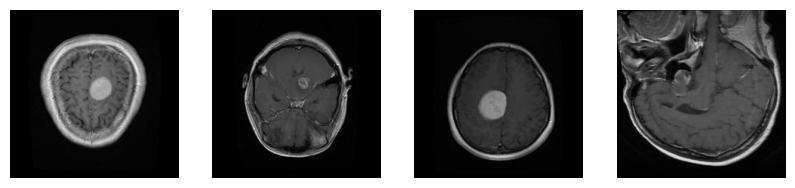

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [5]:
#preprocessing steps
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [6]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (14520, 224, 224, 3)
X_test Shape:  (7152, 224, 224, 3)
y_train Shape:  (14520, 2)
y_test Shape:  (7152, 2)


In [7]:
from tensorflow.keras.applications import ResNet50, VGG16, Xception
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def load_pretrained_models(input_shape):
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the layers
    for model in [resnet, vgg16]:
        for layer in model.layers:
            layer.trainable = False

    return resnet, vgg16
from tensorflow.keras.layers import Dense

# Feature extraction and weighted averaging
def build_hybrid_model(input_shape, weights):
    inputs = Input(shape=input_shape)

    # Load pre-trained models without top classification layer
    resnet, vgg16 = load_pretrained_models(input_shape)

    # Global average pooling of features
    resnet_features = GlobalAveragePooling2D()(resnet(inputs))
    vgg16_features = GlobalAveragePooling2D()(vgg16(inputs))

    # Align feature dimensions using Dense layers (reduce to 512)
    resnet_features = Dense(512, activation='relu')(resnet_features)

    # Weighted sum of features from different models
    hybrid_features = (weights[0] * resnet_features) + \
                      (weights[1] * vgg16_features)

    # Final classification layer (for 2 classes: yes/no)
    hybrid_features_1 = Dense(4096,activation='relu')(hybrid_features)
    output = Dense(2, activation='softmax')(hybrid_features_1)

    model = Model(inputs=inputs, outputs=output)
    return model

    
# Train and evaluate the hybrid model on the brain tumor dataset
input_shape = (224, 224, 3)

# Define different weight ratios to experiment with
weight_ratios = [
    (0.5,0.5),  # Equal weights
    (0.75,0.25),   # ResNet dominance
    (0.25,0.75),   # VGG16 dominance
]

# Best accuracy tracking
best_accuracy = 0
best_weights = None

# Loop through different weight ratios
for weights in weight_ratios:
    print(f"Training with weights: {weights}")
    model = build_hybrid_model(input_shape, weights)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Accuracy with weights {weights}: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = weights

print(f"Best weight ratio: {best_weights} with accuracy: {best_accuracy}")

Training with weights: (0.5, 0.5)
Epoch 1/5
454/454 [==============================] - 4612s 10s/step - loss: 0.1802 - accuracy: 0.9508 - val_loss: 0.0543 - val_accuracy: 0.9804
Epoch 2/5
454/454 [==============================] - 5217s 12s/step - loss: 0.0421 - accuracy: 0.9840 - val_loss: 0.0408 - val_accuracy: 0.9867
Epoch 3/5
454/454 [==============================] - 3144s 7s/step - loss: 0.0368 - accuracy: 0.9855 - val_loss: 0.0541 - val_accuracy: 0.9831
Epoch 4/5
454/454 [==============================] - 3768s 8s/step - loss: 0.0227 - accuracy: 0.9919 - val_loss: 0.1199 - val_accuracy: 0.9670
Epoch 5/5
224/224 [==============================] - 1040s 5s/step - loss: 0.0289 - accuracy: 0.9894
Accuracy with weights (0.5, 0.5): 0.9893736243247986
Training with weights: (0.75, 0.25)
Epoch 1/5
454/454 [==============================] - 3783s 8s/step - loss: 0.1359 - accuracy: 0.9555 - val_loss: 0.0460 - val_accuracy: 0.9843
Epoch 2/5
454/454 [==============================] - 2869s 